# SkipGram Word2Vec RNN

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

## Loading Data

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:12, 2.51MB/s]                            


## Preprocessing Data

In [3]:
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [4]:
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling Data

In [7]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)

freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Building the Network

### Creating Placeholders

In [8]:
train_graph = tf.Graph()

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

### Adding Embedding Layer 

In [9]:
n_vocab = len(int_to_vocab)
# number of embedding features 
n_embedding = 200 

with train_graph.as_default():
    # create embedding weight matrix here
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    # use tf.nn.embedding_lookup to get the hidden layer output
    embed = tf.nn.embedding_lookup(embedding, inputs)

### Adding Softmax Layer Using Negative Sampling

In [10]:
# Number of negative labels to sample
n_sampled = 100

with train_graph.as_default():
    # create softmax weight matrix here
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    # create softmax biases here
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_w,
        biases=softmax_b,
        labels=labels,
        inputs=embed,
        num_sampled=n_sampled,
        num_classes=n_vocab) 
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

### Adding Validation

In [11]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

## Training the Network

### Getting SkipGram Target Words

In [12]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    rand = random.randint(1, window_size+1)
    start = idx-rand if (idx-rand > 0) else 0
    end = idx+rand
    target_words = set(words[start:idx] + words[idx+1:end+1])
    
    return list(target_words)

### Making Batches

In [13]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [14]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

### Training

In [15]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    iteration = 1
    loss = 0

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        
        for x, y in batches:   
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6433 0.0315 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6065 0.0287 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4972 0.0288 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5911 0.0287 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.4912 0.0287 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5591 0.0287 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5270 0.0287 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5658 0.0286 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4822 0.0287 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4730 0.0286 sec/batch
Nearest to on: etude, laird, sindhi, hartmann, fricke, robie, eks, ridden,
Nearest to have: digambar, halld, keen, judiciary, victimization, saunderson, metabolize, naaman,
Nearest to about: witnessing, personal, crafted, stated, wrecking, tullius, frazee, consciences,
Nearest to that: programmer, 

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6661 0.0298 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6535 0.0286 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6191 0.0287 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6140 0.0288 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6306 0.0288 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6334 0.0286 sec/batch
Epoch 2/10 Iteration: 4700 Avg. Training loss: 4.5927 0.0212 sec/batch
Epoch 2/10 Iteration: 4800 Avg. Training loss: 4.5517 0.0287 sec/batch
Epoch 2/10 Iteration: 4900 Avg. Training loss: 4.5214 0.0287 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 4.5145 0.0287 sec/batch
Nearest to on: etude, margaret, laird, ridden, agreed, robie, chiba, fricke,
Nearest to have: beneficial, victimization, easier, digambar, annuities, keen, fourths, shawl,
Nearest to about: witnessing, tullius, crafted, comrie, stated, ripeness, spatial, spaceport,
Nearest to that: program

Epoch 2/10 Iteration: 8100 Avg. Training loss: 4.3703 0.0298 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 4.2989 0.0288 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 4.3866 0.0288 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 4.4037 0.0288 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 4.3916 0.0285 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 4.3061 0.0287 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 4.2995 0.0285 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 4.3434 0.0286 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 4.2234 0.0287 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 4.3302 0.0287 sec/batch
Nearest to on: etude, margaret, robie, ridden, fricke, demigod, agreed, laird,
Nearest to have: annuities, dispersion, beneficial, easier, keen, extent, odie, shawl,
Nearest to about: witnessing, spatial, climate, ripeness, tullius, tend, hahnemann, crafted,
Nearest to that: mandible, whet

Epoch 3/10 Iteration: 12100 Avg. Training loss: 4.2090 0.0297 sec/batch
Epoch 3/10 Iteration: 12200 Avg. Training loss: 4.1666 0.0287 sec/batch
Epoch 3/10 Iteration: 12300 Avg. Training loss: 4.1633 0.0288 sec/batch
Epoch 3/10 Iteration: 12400 Avg. Training loss: 4.1840 0.0288 sec/batch
Epoch 3/10 Iteration: 12500 Avg. Training loss: 4.1835 0.0287 sec/batch
Epoch 3/10 Iteration: 12600 Avg. Training loss: 4.1557 0.0285 sec/batch
Epoch 3/10 Iteration: 12700 Avg. Training loss: 4.1800 0.0287 sec/batch
Epoch 3/10 Iteration: 12800 Avg. Training loss: 4.1363 0.0288 sec/batch
Epoch 3/10 Iteration: 12900 Avg. Training loss: 4.2246 0.0291 sec/batch
Epoch 3/10 Iteration: 13000 Avg. Training loss: 4.2181 0.0287 sec/batch
Nearest to on: margaret, fricke, robie, laughlin, etude, rebranding, agreed, laird,
Nearest to have: annuities, odie, elamo, keen, extent, halld, victimization, circumcision,
Nearest to about: witnessing, spatial, ashmore, biomedicine, climate, passim, disbands, stated,
Nearest t

Epoch 4/10 Iteration: 16100 Avg. Training loss: 4.0727 0.0296 sec/batch
Epoch 4/10 Iteration: 16200 Avg. Training loss: 4.0993 0.0287 sec/batch
Epoch 4/10 Iteration: 16300 Avg. Training loss: 4.0998 0.0288 sec/batch
Epoch 4/10 Iteration: 16400 Avg. Training loss: 4.0843 0.0287 sec/batch
Epoch 4/10 Iteration: 16500 Avg. Training loss: 4.0750 0.0288 sec/batch
Epoch 4/10 Iteration: 16600 Avg. Training loss: 4.0617 0.0288 sec/batch
Epoch 4/10 Iteration: 16700 Avg. Training loss: 4.0870 0.0286 sec/batch
Epoch 4/10 Iteration: 16800 Avg. Training loss: 4.0863 0.0288 sec/batch
Epoch 4/10 Iteration: 16900 Avg. Training loss: 4.0772 0.0287 sec/batch
Epoch 4/10 Iteration: 17000 Avg. Training loss: 4.0847 0.0288 sec/batch
Nearest to on: margaret, agreed, fricke, rebranding, etude, issue, faa, arena,
Nearest to have: annuities, elamo, circumcision, halld, are, with, keen, extent,
Nearest to about: witnessing, spatial, climate, biomedicine, ashmore, around, enlarge, stated,
Nearest to that: mandible

Epoch 5/10 Iteration: 20100 Avg. Training loss: 4.0265 0.0297 sec/batch
Epoch 5/10 Iteration: 20200 Avg. Training loss: 4.0152 0.0287 sec/batch
Epoch 5/10 Iteration: 20300 Avg. Training loss: 3.9570 0.0286 sec/batch
Epoch 5/10 Iteration: 20400 Avg. Training loss: 4.0257 0.0286 sec/batch
Epoch 5/10 Iteration: 20500 Avg. Training loss: 4.0364 0.0288 sec/batch
Epoch 5/10 Iteration: 20600 Avg. Training loss: 3.9527 0.0286 sec/batch
Epoch 5/10 Iteration: 20700 Avg. Training loss: 4.0091 0.0287 sec/batch
Epoch 5/10 Iteration: 20800 Avg. Training loss: 3.9993 0.0285 sec/batch
Epoch 5/10 Iteration: 20900 Avg. Training loss: 4.0068 0.0287 sec/batch
Epoch 5/10 Iteration: 21000 Avg. Training loss: 4.0214 0.0286 sec/batch
Nearest to on: agreed, margaret, fricke, posthumous, september, pursuits, all, rebranding,
Nearest to have: annuities, are, circumcision, adolescent, keen, elamo, halld, danio,
Nearest to about: ashmore, witnessing, spatial, notorious, stated, enlarge, climate, biomedicine,
Neare

Epoch 6/10 Iteration: 24100 Avg. Training loss: 3.9612 0.0296 sec/batch
Epoch 6/10 Iteration: 24200 Avg. Training loss: 3.9938 0.0287 sec/batch
Epoch 6/10 Iteration: 24300 Avg. Training loss: 3.8714 0.0287 sec/batch
Epoch 6/10 Iteration: 24400 Avg. Training loss: 3.9450 0.0286 sec/batch
Epoch 6/10 Iteration: 24500 Avg. Training loss: 3.9405 0.0287 sec/batch
Epoch 6/10 Iteration: 24600 Avg. Training loss: 3.9069 0.0285 sec/batch
Epoch 6/10 Iteration: 24700 Avg. Training loss: 3.9622 0.0287 sec/batch
Epoch 6/10 Iteration: 24800 Avg. Training loss: 3.9928 0.0286 sec/batch
Epoch 6/10 Iteration: 24900 Avg. Training loss: 3.9343 0.0286 sec/batch
Epoch 6/10 Iteration: 25000 Avg. Training loss: 3.9409 0.0286 sec/batch
Nearest to on: agreed, posthumous, all, september, contour, arena, points, fricke,
Nearest to have: are, annuities, with, circumcision, gymnosperms, danio, caviar, needed,
Nearest to about: ashmore, around, clues, spatial, climate, notorious, enlarge, biomedicine,
Nearest to that

Epoch 7/10 Iteration: 28100 Avg. Training loss: 3.9258 0.0299 sec/batch
Epoch 7/10 Iteration: 28200 Avg. Training loss: 3.9321 0.0288 sec/batch
Epoch 7/10 Iteration: 28300 Avg. Training loss: 3.9190 0.0287 sec/batch
Epoch 7/10 Iteration: 28400 Avg. Training loss: 3.8975 0.0288 sec/batch
Epoch 7/10 Iteration: 28500 Avg. Training loss: 3.8933 0.0287 sec/batch
Epoch 7/10 Iteration: 28600 Avg. Training loss: 3.9340 0.0288 sec/batch
Epoch 7/10 Iteration: 28700 Avg. Training loss: 3.9197 0.0287 sec/batch
Epoch 7/10 Iteration: 28800 Avg. Training loss: 3.9714 0.0286 sec/batch
Epoch 7/10 Iteration: 28900 Avg. Training loss: 3.8448 0.0288 sec/batch
Epoch 7/10 Iteration: 29000 Avg. Training loss: 3.8749 0.0289 sec/batch
Nearest to on: agreed, september, all, listing, of, topographic, contour, ferrat,
Nearest to have: are, caviar, extent, jewelers, gymnosperms, were, with, annuities,
Nearest to about: ashmore, climate, enlarge, around, clues, wojew, two, notorious,
Nearest to that: whether, which

Epoch 7/10 Iteration: 32100 Avg. Training loss: 3.9152 0.0305 sec/batch
Epoch 7/10 Iteration: 32200 Avg. Training loss: 3.9271 0.0292 sec/batch
Epoch 7/10 Iteration: 32300 Avg. Training loss: 3.9113 0.0293 sec/batch
Epoch 8/10 Iteration: 32400 Avg. Training loss: 3.9321 0.0035 sec/batch
Epoch 8/10 Iteration: 32500 Avg. Training loss: 3.9143 0.0293 sec/batch
Epoch 8/10 Iteration: 32600 Avg. Training loss: 3.8835 0.0294 sec/batch
Epoch 8/10 Iteration: 32700 Avg. Training loss: 3.8845 0.0295 sec/batch
Epoch 8/10 Iteration: 32800 Avg. Training loss: 3.9068 0.0294 sec/batch
Epoch 8/10 Iteration: 32900 Avg. Training loss: 3.8744 0.0295 sec/batch
Epoch 8/10 Iteration: 33000 Avg. Training loss: 3.8671 0.0295 sec/batch
Nearest to on: of, agreed, september, the, by, all, contour, which,
Nearest to have: are, were, with, still, that, extent, for, furthermore,
Nearest to about: ashmore, around, clues, climate, wojew, to, enlarge, size,
Nearest to that: to, be, some, do, which, whether, however, th

Epoch 8/10 Iteration: 36400 Avg. Training loss: 3.8515 0.0292 sec/batch
Epoch 8/10 Iteration: 36500 Avg. Training loss: 3.9139 0.0292 sec/batch
Epoch 8/10 Iteration: 36600 Avg. Training loss: 3.8568 0.0293 sec/batch
Epoch 8/10 Iteration: 36700 Avg. Training loss: 3.8700 0.0296 sec/batch
Epoch 8/10 Iteration: 36800 Avg. Training loss: 3.8900 0.0296 sec/batch
Epoch 8/10 Iteration: 36900 Avg. Training loss: 3.8820 0.0294 sec/batch
Epoch 8/10 Iteration: 37000 Avg. Training loss: 3.9387 0.0295 sec/batch
Nearest to on: of, by, all, the, agreed, september, which, a,
Nearest to have: are, made, still, extent, with, that, however, were,
Nearest to about: ashmore, clues, climate, wojew, two, enlarge, around, births,
Nearest to that: however, a, to, has, be, would, which, have,
Nearest to such: are, lightweight, based, apocrypha, with, as, of, other,
Nearest to a: of, is, in, the, s, and, that, by,
Nearest to and: of, the, to, in, by, as, with, for,
Nearest to has: that, of, since, recently, can,

Epoch 9/10 Iteration: 40700 Avg. Training loss: 3.9898 0.0296 sec/batch
Epoch 9/10 Iteration: 40800 Avg. Training loss: 3.9279 0.0294 sec/batch
Epoch 9/10 Iteration: 40900 Avg. Training loss: 3.9343 0.0294 sec/batch
Epoch 9/10 Iteration: 41000 Avg. Training loss: 3.8315 0.0295 sec/batch
Nearest to on: of, by, the, agreed, all, september, which, for,
Nearest to have: are, still, made, that, however, extent, were, there,
Nearest to about: ashmore, two, clues, wojew, climate, notorious, enlarge, around,
Nearest to that: be, has, however, which, a, to, have, would,
Nearest to such: are, as, of, other, based, or, with, and,
Nearest to a: of, is, in, and, the, often, also, for,
Nearest to and: of, the, to, in, as, for, with, by,
Nearest to has: that, of, since, is, by, does, ita, there,
Nearest to powers: fermionic, merwe, tailplane, fascism, papadopoulos, commonality, brown, udi,
Nearest to placed: was, gauls, rieur, proteobacteria, maul, layperson, chuppah, retouched,
Nearest to discovered

Epoch 10/10 Iteration: 45100 Avg. Training loss: 3.8790 0.0306 sec/batch
Epoch 10/10 Iteration: 45200 Avg. Training loss: 3.8711 0.0297 sec/batch
Epoch 10/10 Iteration: 45300 Avg. Training loss: 3.9209 0.0295 sec/batch
Epoch 10/10 Iteration: 45400 Avg. Training loss: 3.9012 0.0294 sec/batch
Epoch 10/10 Iteration: 45500 Avg. Training loss: 3.8883 0.0293 sec/batch
Epoch 10/10 Iteration: 45600 Avg. Training loss: 3.8390 0.0293 sec/batch
Epoch 10/10 Iteration: 45700 Avg. Training loss: 3.7896 0.0293 sec/batch
Epoch 10/10 Iteration: 45800 Avg. Training loss: 3.8773 0.0293 sec/batch
Epoch 10/10 Iteration: 45900 Avg. Training loss: 3.7471 0.0294 sec/batch
Epoch 10/10 Iteration: 46000 Avg. Training loss: 3.8874 0.0294 sec/batch
Nearest to on: of, all, by, the, september, which, first, for,
Nearest to have: are, that, however, made, still, there, been, were,
Nearest to about: ashmore, wojew, around, two, clues, births, to, climate,
Nearest to that: be, however, have, a, to, not, which, has,
Nea

## Restoring the Network

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the Word Vectors

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

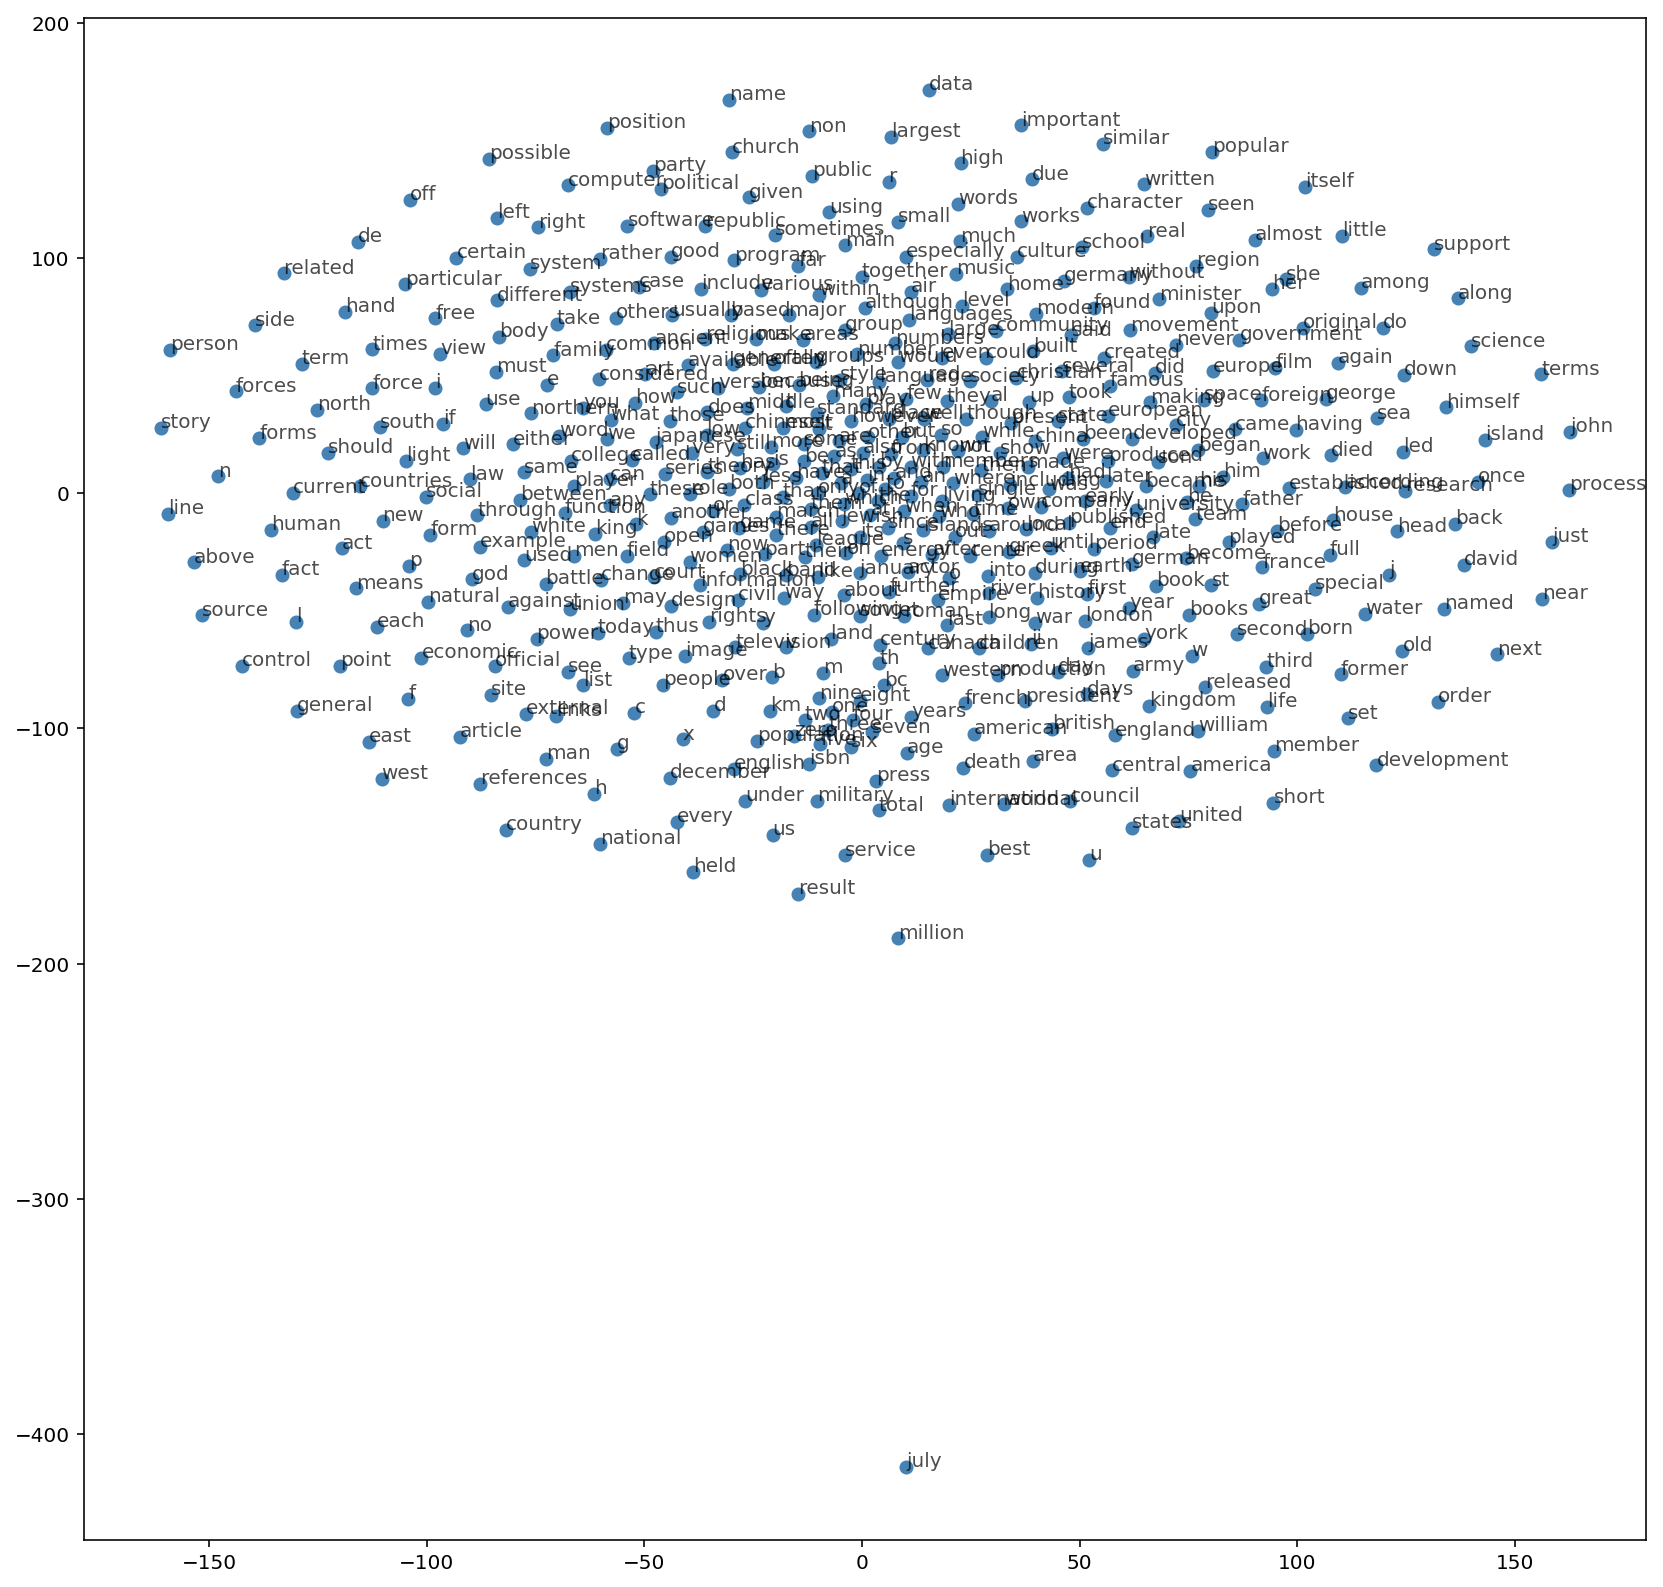

In [19]:
fig, ax = plt.subplots(figsize=(14, 14))

for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)